# Block Chain Markov Chains

[Remember the RCT2 example](2020/08/12/rct2-solution.html)? We built up a Markov chain recursively, found a linear recurrence relation, and used that to devise a formula for expected absorption time that was analytically solvable.

I suggestively coded the solution using `sympy`, pointing to a more generic algorithmization. This post examines just that question. Given a Markov chain with inductive block chain structure, i.e, it has two levels of heierarchy, and the transient states have the same structure, can we algorithmically derive absorption time?

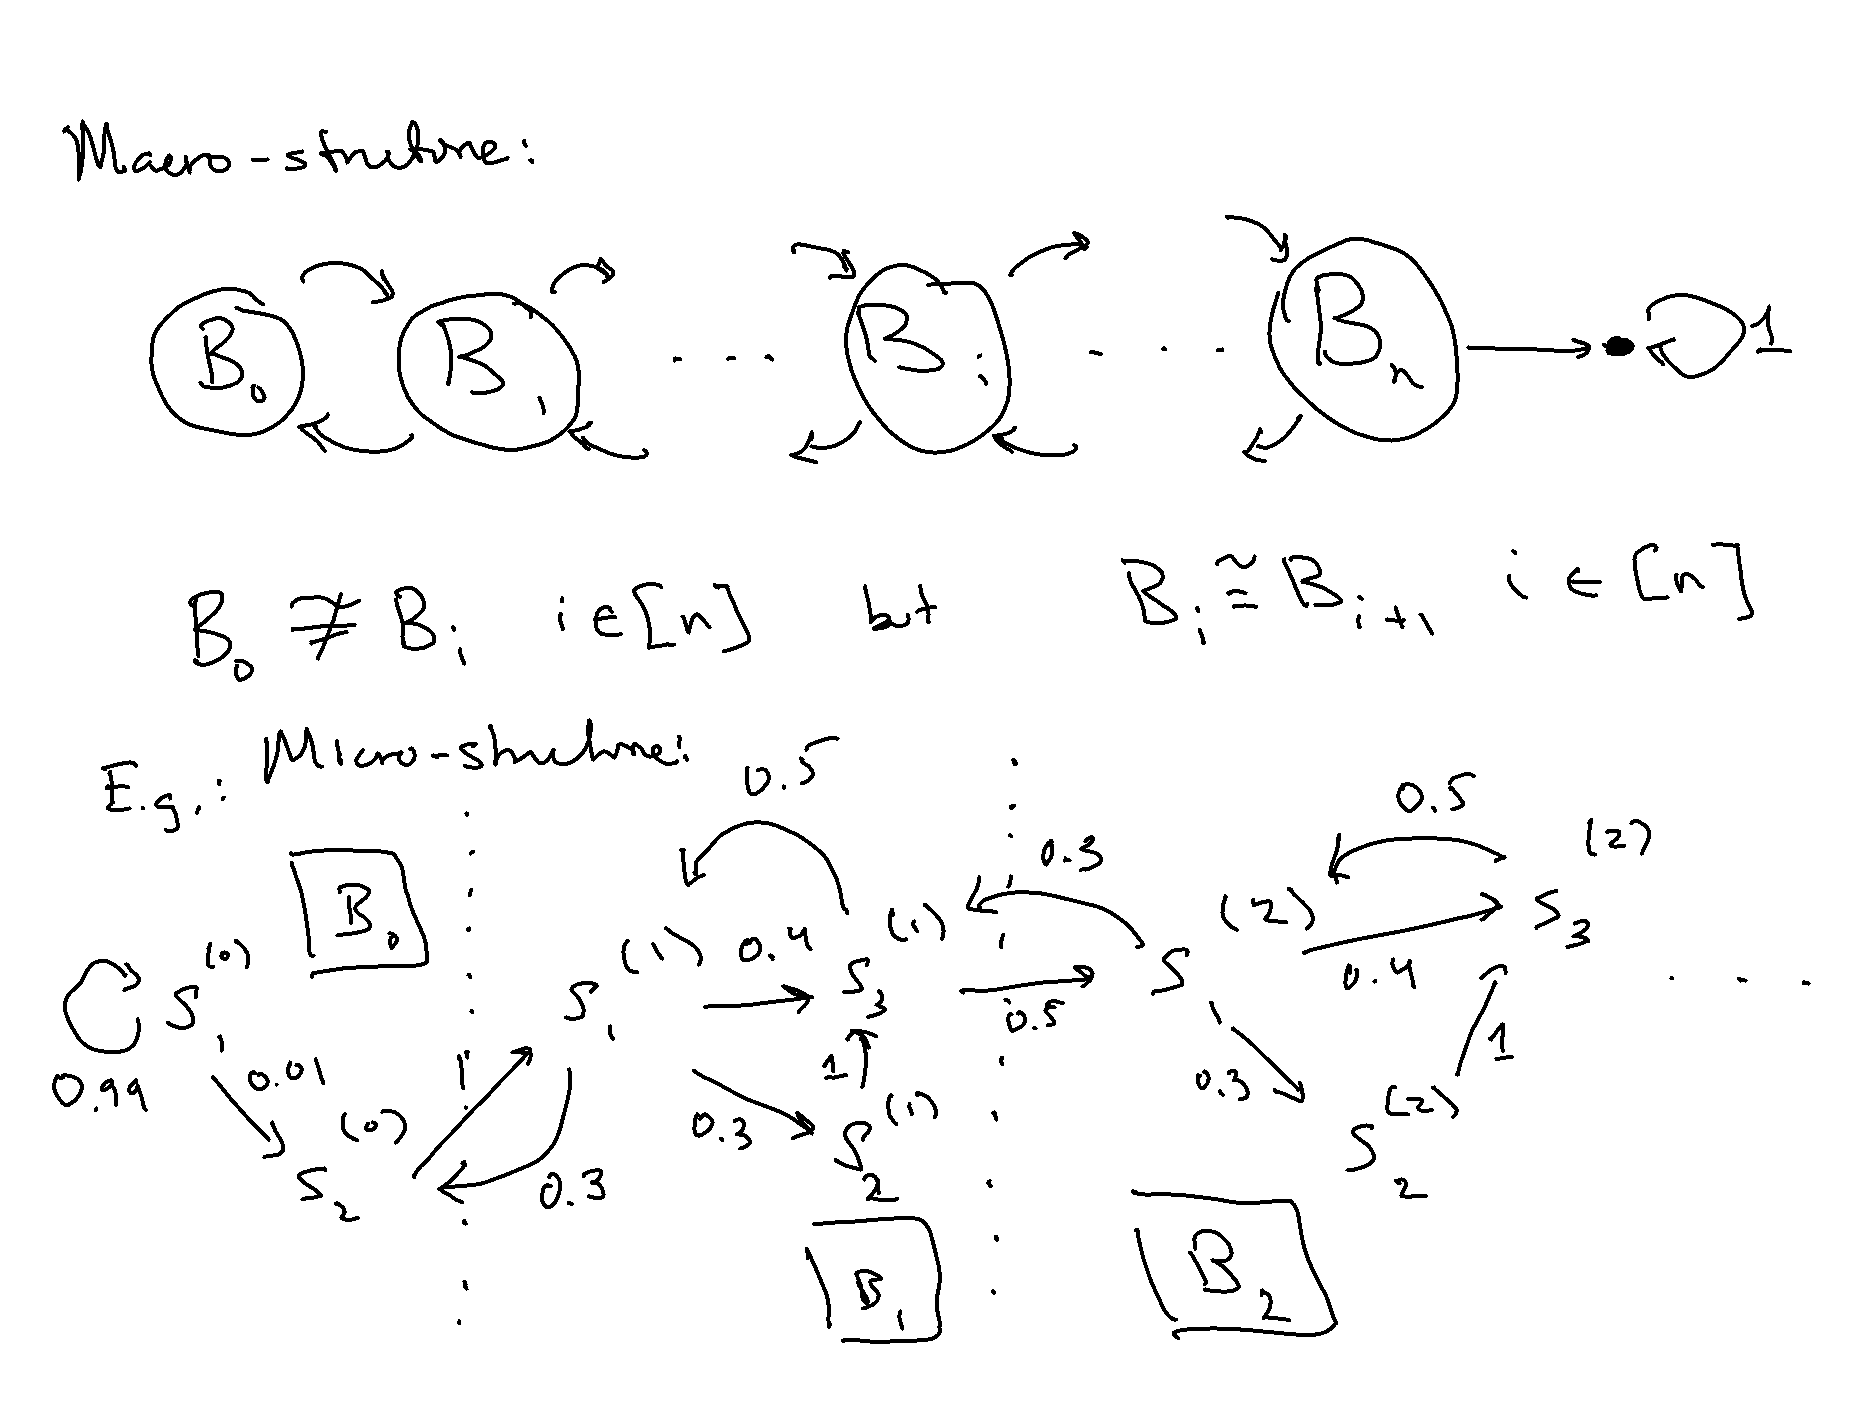

In [1]:
from IPython.display import Image
Image(filename='2020-09-13-block-chain-markov-chains/macro-micro.png') 

Notably, the internal structure is shared for $B_i$, but the initial states can differ.

We allow more than one state from $B_i$ to transition to $B_{i+1}$ and similarly for the opposite direction.

This yields a block-structured transition matrix $P$ for which $p_{ij}$ is the transition probability from state $i$ to state $j$. In particular,

$$
P_n=\begin{pmatrix}P_{n-1}&(\mathbf{0}|V_n)^\top\\ \mathbf{0}|U_n & C_n\end{pmatrix}\,\,,
$$

with the recursion holding until $P_0=C_0$. Suppose $C_0$ has $s_0$ states, so is $s_0\times s_0$, and all other transitions have $s$ states. This makes $V_i,U_i,C_i$ all equal to the same $s\times s$ matrices $V, U, C$ for all $i\in[n]$. Of course, $V$ captures transition probabilities from any states in $B_{i}$ to $B_{i+1}$ and $U$ does the reverse. $C$ manages state transitions within a macro-block.

The absorption times are then given by the solution to the system $(I-P)\mathbf{x}=\mathbf{1}$, as [described here](/2020/08/11/roller-coaster-tycoon-problem.html). This requires solving an $sn\times sn$ linear system, so we developed a custom solution that resolved it in time **independent** of $n$ via eigendecomposition.

This is interesting, because $(I-P)$, like $P$, is block-triadiagonal and (mostly) Toeplitz. For simplicity, let's assume $C_0=C_1$ for now. Then define the BTT operator (for block-tridiagonal and block-Toeplitz) such that $\mathrm{BTT}(U, C, V^\top)$. Even better, we could symmetrize $\mathrm{BTT}(U, C, V^\top)=\mathrm{BTT}(A^\top, B, A)\mathrm{BTT}(E^\top, D, E)$ with well chosen $A, B, D, E$ satisfying linear equations $A^\top D+BE^\top = U$, $BD=C$, $BE+AD=V$, $AE=0$. Then if we could solve symmetric BTT systems quickly, then we'd need to solve just two (as well as find such matrices $A, B, D, E$, but those are all of size $s\times s$. However, [this SO question](https://math.stackexchange.com/questions/3168521/inverse-of-symmetric-tridiagonal-block-toeplitz-matrix) and [this overview paper](https://iopscience.iop.org/article/10.1088/1749-4699/5/1/014009/meta) all point to linear-in-$ns^2$ solutions: a recursive definition of the solution is constructed, and then some form of backsolving across blocks is performed. An extension to [the Thomas algorithm](https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm) seems similar (I saw it mentioned in another SO answer).

Such BTT and symmetric BTT equations come up in Eulerized differential equations with local effects, so it's clear why such structured matrices are so well studied, but unfortunately all provided algorithms are computational, expressed as recurrences.

I attempted to approach inverting $I - \mathrm{BTT}(U, C, V^\top)$ with direct methods such as Schur complements and the Woodbury matrix identity, but this didn't give.

## Why is solution for absorption special?

It's strange that directly solving BTT matrices is expensive, but a couple blog posts ago we could solve the BTT system $(I-P)\mathbf{x}=\mathbf{1}$ in time independent of $n$. Are all these algorithms missing something?

The special structure of our absorption time equation comes down to:

 - A structured image $\mathbf{1}$ (which repeats across blocks; of course if $\mathbf{1}$ was not $s$-periodic in its indices then we'd need some $O(n)$ time algorithm)
 - $P$ bistochasticity (except last few rows when excluding absorption states)
 - Markov chain transience
 
Since $P$ is a transition matrix, its spectral radius $\rho(P)\le 1$. Since it's transient, $\rho(P)<1$. A solution $\mathbf{x}$ to $(I-P)\mathbf{x}=\mathbf{1}$ then exists, as $I-P\succ 0$ is nonsingular.
The solution $\mathbf{x}$ which exists and is unique must satisfy $\mathbf{x}=\mathbf{1}+ P\mathbf{x}$ (simply expanding the term on the LHS).

## A First Attempt

Let $\mathbf{x}^\top=\begin{pmatrix}\mathbf{x}_0&\cdots&\mathbf{x}_n\end{pmatrix}$ for conformal $\mathbf{x}_i$ of sizes $s_0,s,\cdots,s$. Inspecting the $i$-th block of $\mathbf{x}=\mathbf{1}+ P\mathbf{x}$ yields for $1<i<n$ that
$$
\mathbf{x}_{i}=\mathbf{1}_s+U\mathbf{x}_{i-1}+C\mathbf{x}_{i}+V^\top \mathbf{x}_{i+1}\,\,,
$$
which can be rewritten as
$$
\mathbf{x}_{i}=(I-C)^{-1}(\mathbf{1}_s+U\mathbf{x}_{i-1}+V^\top \mathbf{x}_{i+1})\,\,,
$$
since $\rho(C)<1$ is implied by $\rho(P)<1$, as $C$ is the restriction of $P$ to the subspace for the $i$-th block, so $I-C$ is also nonsingular.

By itself, expressing the $i$-th block in terms of the $(i-1)$-st and $(i+1)$-st isn't too helpful: such a recurrence doesn't bottom out (at least not obviously). Naively, if $U$ was somehow nonsingular then we could express $\mathbf{x}_{i-1}$ in terms of $\mathbf{x}_i,\mathbf{x}_{i+1}$, which does clearly terminate.

## A Second Attempt

Writing $U=L\Sigma R^\top$ as the full SVD for unitary $s\times s$ matrices $L, R$, and $\Sigma=\begin{pmatrix}
I_r & 0\\
0 & 0_{s-r}
\end{pmatrix}$ for the rank $r$ of $U$, let's multiply each block of the equation $(I-P)\mathbf{x}=\mathbf{1}$ by $L^\top$ on the left and $R$ on the right. Note we don't need to treat the edge case $r=0$ differently. Letting $\mathbf{y}_i= R^\top \mathbf{x}_i$ for every block $n\ge i >1$ we are left with for every $i$,
$$
\begin{gather*}
&-L^\top  L\Sigma R^\top R\mathbf{y}_{i-1}+
L^\top(I-C)R\mathbf{y}_i-
L^\top V^\top R\mathbf{y}_{i+1}\\
=&\begin{pmatrix}
-I_r & 0\\
0 & 0
\end{pmatrix}\mathbf{y}_{i-1} + A\mathbf{y}_i+B\mathbf{y}_{i+1}\\
=&L^\top\mathbf{1}\,\,.
\end{gather*}
$$
Above, $A,B$ are suitably defined, where we note that since $L,R$ are unitary, $A$ is nonsingular, and we let $\mathbf{y}_{n+1}=\mathbf{0}$ for the last equation. 


Now, to consider fully determined systems, we need to think about re-indexing. Our current block indexing is by $s_0,s,\cdots,s$:
$$
\mathbf{y}^\top=\begin{pmatrix}\mathbf{x}_0&\mathbf{y}_1&\cdots&\mathbf{y}_{n-1}&\mathbf{x}_n & \mathbf{0}_s\end{pmatrix}\,\,,
$$
but consider instead blocking by $s_0 + r, s, \cdots s$ by extending with more zeros so that
$$
(\mathbf{y}')^\top=\begin{pmatrix}\mathbf{y}_0'&\mathbf{y}_1'&\cdots&\mathbf{y}_{n-1}'&\mathbf{y}_n' & \mathbf{0}_s\end{pmatrix}\,\,,
$$
where $(\mathbf{y}_0')^\top =\mathbf{x}_0^\top|(\mathbf{y}_1)_{1:r}^\top$, $(\mathbf{y}_{n-1}')^\top =(\mathbf{y}_{n-1})_{r+1:s}^\top|(\mathbf{x}_n)_{1:r}^\top$, $(\mathbf{y}_{n}')^\top =(\mathbf{x}_{n})_{r+1:s}^\top|\mathbf{0}_r^\top$. All this hard work yields the shifted equations
$$
\begin{pmatrix}
A_{s-r,r} & A_{s-r}\\
 -I_r & 0
\end{pmatrix}\mathbf{y}_{i-1}' + \begin{pmatrix}
B_{s-r,r} & B_{s-r}\\
A_{r} & A_{r,s-r}
\end{pmatrix}\mathbf{y}_i'+\begin{pmatrix}
0 & 0\\
B_{r} & A_{r,s-r}
\end{pmatrix}\mathbf{y}_{i+1}'
=\begin{pmatrix}
(L^\top)_{s-r,s}\\(L^\top)_{r, s}
\end{pmatrix}\mathbf{1}\,\,,
$$
where we conformably break the $s\times s$ matrix $A=\begin{pmatrix}
A_r & A_{r,s-r}\\
A_{s-r,r} & A_{s-r}
\end{pmatrix}$, and similarly for others, e.g. $L^\top=\begin{pmatrix}
(L^\top)_{r, s}\\
(L^\top)_{s-r,s}
\end{pmatrix}$.

For all the marbles, we ask whether $\begin{pmatrix}
A_{s-r,r} & A_{s-r}\\
 -I_r & 0
\end{pmatrix}$ is invertible. I haven't figured this out yet (TODO). But, assuming it is, then we can solve the linear system above for $\mathbf{y}_{i-1}'=T(\mathbf{y}_i,\mathbf{y}_{i+1})$.

TODO make it square

$$
(\mathbf{y}_0,\mathbf{x}_1,\mathbf{x}_2)=T_0(\mathbf{x}_2,\mathbf{x}_3, \mathbf{x}_4,\mathbf{1}_s)=T_0T^{n-1}(\mathbf{x}_{n-1},\mathbf{x}_n,\mathbf{1}_s)\,\,,
$$

TODO exponentiate as above

Backsolve x